In [42]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [346]:
euro = pd.read_csv('./data/eurovision/cleaned_data.csv')
mino = pd.read_csv("./data/minorities/_eurostat_cleared_data.csv")
popu = pd.read_csv("./data/minorities/_population_data.csv")

In [347]:
THRESHOLDS_CUT = [85, 90, 95] # only top 15%, 10% or 5% edges are counted as significant
# Z_THRESHOLD = 1 # cca 0.933

## Significant minorities

In [348]:
sig_matrix = mino.merge(popu, left_on="citizen_name", right_on="country")
len(sig_matrix["citizen_name"].unique())

47

In [349]:
len(sig_matrix.dropna()) == len(sig_matrix)

True

In [350]:
sig_matrix['percent_pop'] = (sig_matrix['head_count'] / sig_matrix['population']) * 100
sig_matrix.head()

,citizen_name,minority_name,head_count,country,population,percent_pop
0,Albania,Austria,6592.0,Albania,3107100,0.212159
1,Albania,Belgium,3176.0,Albania,3107100,0.102218
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152
3,Albania,Cyprus,388.0,Albania,3107100,0.012488
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143


### Treshhold signinficance

In [351]:
for thr in THRESHOLDS_CUT:
    threshold = np.percentile(sig_matrix["percent_pop"], thr)
    sig_matrix[f'significant_threshold_{thr}'] = sig_matrix['percent_pop'] > threshold

In [352]:
sig_matrix.head()

,citizen_name,minority_name,head_count,country,population,percent_pop,significant_threshold_85,significant_threshold_90,significant_threshold_95
0,Albania,Austria,6592.0,Albania,3107100,0.212159,True,False,False
1,Albania,Belgium,3176.0,Albania,3107100,0.102218,False,False,False
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152,False,False,False
3,Albania,Cyprus,388.0,Albania,3107100,0.012488,False,False,False
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143,False,False,False


In [353]:
for thr in THRESHOLDS_CUT:
    print(sig_matrix[f'significant_threshold_{thr}'].value_counts())

significant_threshold_85
False    1082
True      191
Name: count, dtype: int64
significant_threshold_90
False    1145
True      128
Name: count, dtype: int64
significant_threshold_95
False    1209
True       64
Name: count, dtype: int64


### Visualization

In [354]:
def vizualize(df, title = "Network of European Countries by Minority Percentage"):
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(row["citizen_name"], row["minority_name"], weight=row["percent_pop"])
    pos = nx.spring_layout(G, seed=1001)
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(title)
    plt.axis("off")
    plt.show()

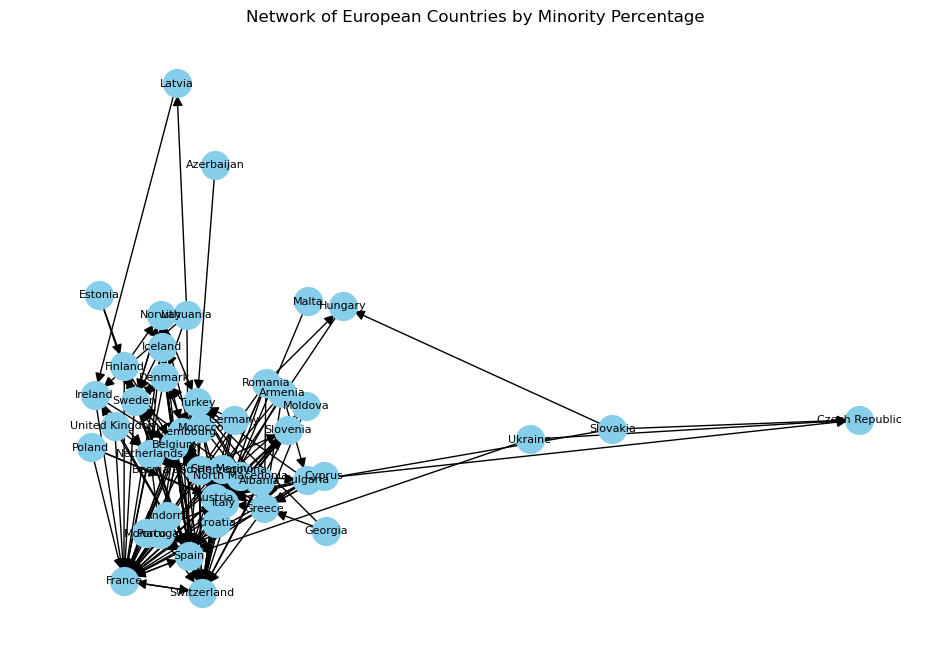

In [355]:
vizualize(sig_matrix[sig_matrix['significant_threshold_85']])

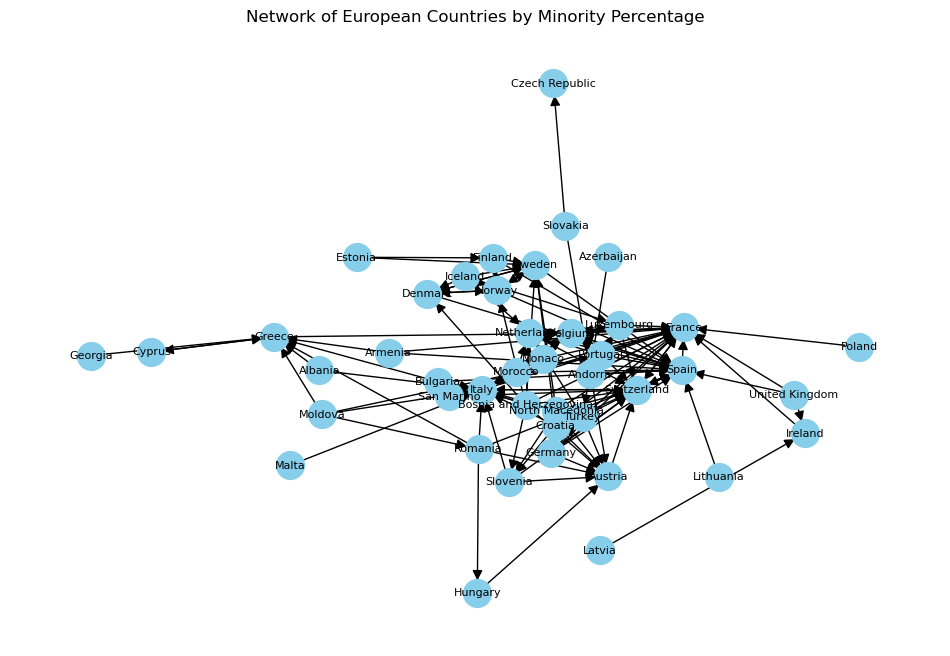

In [356]:
vizualize(sig_matrix[sig_matrix['significant_threshold_90']])

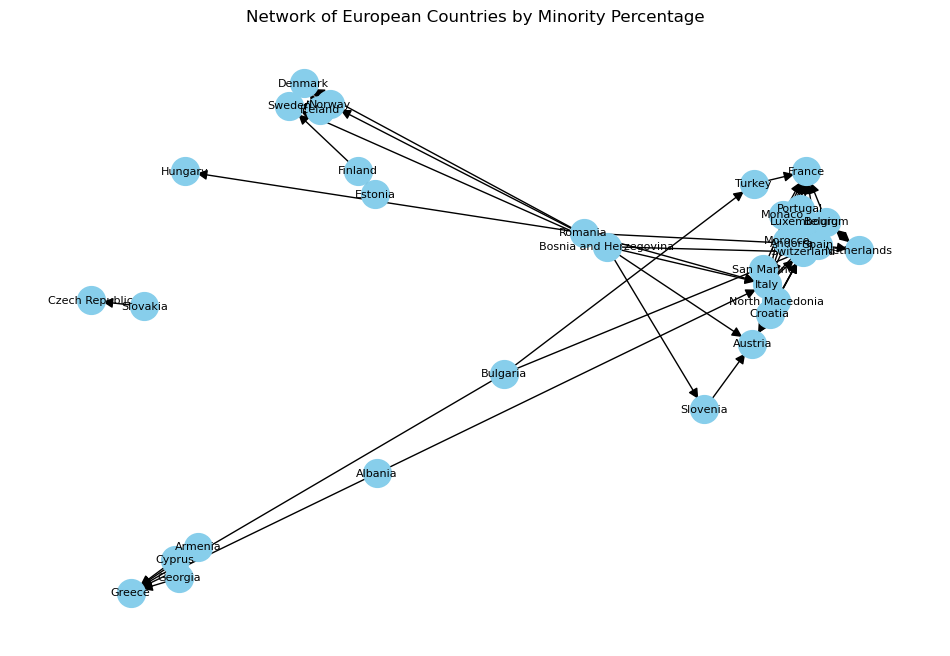

In [357]:
vizualize(sig_matrix[sig_matrix['significant_threshold_95']])

## Significant eurovision voting

In [358]:
euro = euro[euro["year"] > 2008]
euro.head()

,year,from_country,to_country,promil_scale
21595,2009,Albania,Norway,0.075431
21596,2009,Albania,Iceland,0.064655
21597,2009,Albania,Azerbaijan,0.043103
21598,2009,Albania,Turkey,0.107759
21599,2009,Albania,United Kingdom,0.086207


### Avereged

In [359]:
avg = (
    euro[["from_country", "to_country", "promil_scale"]]
    .groupby(["from_country", "to_country"])
    .sum()
    .merge(
        euro[["from_country", "to_country", "year"]].groupby(["from_country", "to_country"]).count(),
        on=["from_country", "to_country"],
    )
    .rename(columns={"promil_scale": "promil_sum", "year": "years_amount"})
    .reset_index()
)
avg

,from_country,to_country,promil_sum,years_amount
0,Albania,Albania,0.000000,8
1,Albania,Armenia,0.141270,9
2,Albania,Australia,0.228021,7
3,Albania,Austria,0.078170,7
4,Albania,Azerbaijan,0.364911,12
...,...,...,...,...
1895,United Kingdom,Sweden,0.797980,13
1896,United Kingdom,Switzerland,0.251600,6
1897,United Kingdom,Turkey,0.264546,3
1898,United Kingdom,Ukraine,0.356676,12


In [360]:
avg['standardized'] = avg['promil_sum'] / avg['years_amount']
avg = avg.drop(columns=['promil_sum', 'years_amount'])
avg

,from_country,to_country,standardized
0,Albania,Albania,0.000000
1,Albania,Armenia,0.015697
2,Albania,Australia,0.032574
3,Albania,Austria,0.011167
4,Albania,Azerbaijan,0.030409
...,...,...,...
1895,United Kingdom,Sweden,0.061383
1896,United Kingdom,Switzerland,0.041933
1897,United Kingdom,Turkey,0.088182
1898,United Kingdom,Ukraine,0.029723


#### Threshold signinficance

In [368]:
for thr in THRESHOLDS_CUT:
    threshold = np.percentile(avg["standardized"], thr)
    avg[f'significant_threshold_{thr}'] = avg['standardized'] > threshold
    avg.head()

In [370]:
for thr in THRESHOLDS_CUT:
    print(avg[f'significant_threshold_{thr}'].value_counts())

significant_threshold_85
False    1615
True      285
Name: count, dtype: int64
significant_threshold_90
False    1710
True      190
Name: count, dtype: int64
significant_threshold_95
False    1805
True       95
Name: count, dtype: int64


### Year-over-year

In [333]:
yoy_dict = {}

In [384]:
for group, group_df in euro[['year', 'from_country', 'to_country', 'promil_scale']].groupby('year'):
    for thr in THRESHOLDS_CUT:
        threshold = np.percentile(group_df["promil_scale"], thr)
        group_df[f'significant_threshold_{thr}'] = group_df['promil_scale'] > threshold

    yoy_dict[group] = group_df

In [385]:
yoy_dict[2019]

,year,from_country,to_country,promil_scale,significant_threshold_85,significant_threshold_90,significant_threshold_95
31392,2019,Albania,Netherlands,0.040253,False,False,False
31393,2019,Albania,Italy,0.074755,True,False,False
31394,2019,Albania,Russia,0.074755,True,False,False
31395,2019,Albania,Switzerland,0.080506,True,False,False
31396,2019,Albania,Sweden,0.034502,False,False,False
...,...,...,...,...,...,...,...
32362,2019,United Kingdom,Spain,0.011501,False,False,False
32363,2019,United Kingdom,Israel,0.000000,False,False,False
32364,2019,United Kingdom,Belarus,0.000000,False,False,False
32365,2019,United Kingdom,Germany,0.000000,False,False,False


## Significance graphs comparison

In [336]:
# def get_weighted_graph(df: pd.DataFrame, src: str, dst: str, weight: str) -> nx.DiGraph:
#     graph = nx.DiGraph()
#     for _, row in df.iterrows():
#         graph.add_edge(row[src], row[dst], weight=row[weight])
#     return graph


# G_minorities_weighted = get_weighted_graph(sig_matrix, "citizen_name", "minority_name", "percent_pop")
# G_votes_weighted = get_weighted_graph(avg, "from_country", "to_country", "promil_scale")

In [363]:
sig_matrix

,citizen_name,minority_name,head_count,country,population,percent_pop,significant_threshold_85,significant_threshold_90,significant_threshold_95
0,Albania,Austria,6592.0,Albania,3107100,0.212159,True,False,False
1,Albania,Belgium,3176.0,Albania,3107100,0.102218,False,False,False
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152,False,False,False
3,Albania,Cyprus,388.0,Albania,3107100,0.012488,False,False,False
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143,False,False,False
...,...,...,...,...,...,...,...,...,...
1268,United Kingdom,Slovenia,250.0,United Kingdom,68459055,0.000365,False,False,False
1269,United Kingdom,Spain,379448.0,United Kingdom,68459055,0.554270,True,True,False
1270,United Kingdom,Sweden,52248.0,United Kingdom,68459055,0.076320,False,False,False
1271,United Kingdom,Switzerland,89412.0,United Kingdom,68459055,0.130607,False,False,False


In [364]:
all_countries = [
    "Albania",
    "Andorra",
    "Armenia",
    "Australia",
    "Austria",
    "Azerbaijan",
    "Belarus",
    "Belgium",
    "Bosnia and Herzegovina",
    "Bulgaria",
    "Croatia",
    "Cyprus",
    "Denmark",
    "Estonia",
    "Finland",
    "France",
    "Georgia",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Ireland",
    "Israel",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Moldova",
    "Monaco",
    "Morocco",
    "Netherlands",
    "North Macedonia",
    "Norway",
    "Poland",
    "Portugal",
    "Romania",
    "Russia",
    "San Marino",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Switzerland",
    "Turkey",
    "Ukraine",
    "United Kingdom",
]

def get_unweighted_graph(df: pd.DataFrame, src: str, dst: str, isEdge: str) -> nx.DiGraph:
    graph = nx.DiGraph()
    for _, row in df.iterrows():
        if row[isEdge]:
            graph.add_edge(row[src], row[dst])
    for node in all_countries:
        graph.add_node(node)
    to_remove = []
    for node in graph.nodes:
        if node not in all_countries:
            to_remove.append(node)
    for node in to_remove:
        graph.remove_node(node)
    return graph


In [373]:
graphs_minorities = {thr: get_unweighted_graph(sig_matrix, "citizen_name", "minority_name", f"significant_threshold_{thr}") for thr in THRESHOLDS_CUT}
graphs_votes_avg = {thr: get_unweighted_graph(avg, "from_country", "to_country", f"significant_threshold_{thr}") for thr in THRESHOLDS_CUT}

### Graph Edit Distance

In [397]:
import networkx as nx
import numpy as np
from scipy.stats import norm

def ged(G1, G2):
    ged = nx.graph_edit_distance(G1, G2, timeout=20)
    return ged

def generate_random_graph(num_nodes, num_edges):
    G = nx.gnm_random_graph(num_nodes, num_edges, directed=True)
    return G

mean_geds = {}
std_geds = {}
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    num_random_graphs = 20
    g_minorities = graphs_minorities[thr]
    random_graphs = [generate_random_graph(len(g_minorities.nodes), len(g_minorities.edges)) for _ in range(num_random_graphs)]
    geds = [ged(g_minorities, G) for G in random_graphs]
    mean_geds[thr] = np.mean(geds)
    std_geds[thr] = np.std(geds)
    print(f"Random Graphs (threshold) - Mean GED: {mean_geds[thr]}, Std GED: {std_geds[thr]}")


THRESHOLD = 85
Random Graphs (threshold) - Mean GED: 338.1, Std GED: 8.18474190185616
THRESHOLD = 90
Random Graphs (threshold) - Mean GED: 237.1, Std GED: 5.038849074937649
THRESHOLD = 95
Random Graphs (threshold) - Mean GED: 121.6, Std GED: 2.4979991993593593


#### Averaged vote analysis

In [400]:
def test_if_similar(g1, g2, mean, std, label):
    known_ged = ged(g1, g2)
    z_score = (known_ged - mean) / std
    p_value = norm.cdf(z_score)
    if p_value < 0.05:
        print(f"GED between G1 and G2: {known_ged}, Z-Score: {z_score}, P-Value (one-tailed): {p_value}, {label} are similar.")
        return True
    else:
        print(f"GED between G1 and G2: {known_ged}, Z-Score: {z_score}, P-Value (one-tailed): {p_value}, {label} are not similar.")
        return False

for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    test_if_similar(graphs_minorities[thr], graphs_votes_avg[thr], mean_geds[thr], std_geds[thr], "Minorities and votes graphs ")

THRESHOLD = 85
GED between G1 and G2: 363.0, Z-Score: 3.0422462062429947, P-Value (one-tailed): 0.9988259012927446, Minorities and votes graphs  are not similar.
THRESHOLD = 90
GED between G1 and G2: 273.0, Z-Score: 7.1246428432556765, P-Value (one-tailed): 0.9999999999994782, Minorities and votes graphs  are not similar.
THRESHOLD = 95
GED between G1 and G2: 133.0, Z-Score: 4.563652383444985, P-Value (one-tailed): 0.9999974864354616, Minorities and votes graphs  are not similar.


#### Year to year analysis

In [401]:
simiar_ged = {}
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    simiar_ged[thr] = {}
    for year, vote_g in yoy_dict.items():
        g_minorities = graphs_minorities[thr]
        g_votes = get_unweighted_graph(vote_g, "from_country", "to_country", f"significant_threshold_{thr}")
        simiar_ged[thr][year] = test_if_similar(g_minorities, g_votes, mean_geds[thr], std_geds[thr], f"Minorities and votes graphs (year {year}) ")
simiar_ged

THRESHOLD = 85
GED between G1 and G2: 231.0, Z-Score: -13.085324043719885, P-Value (one-tailed): 1.9972651024654224e-39, Minorities and votes graphs (year 2009)  are similar.
GED between G1 and G2: 219.0, Z-Score: -14.551466793716509, P-Value (one-tailed): 2.858202844484498e-48, Minorities and votes graphs (year 2010)  are similar.
GED between G1 and G2: 238.0, Z-Score: -12.230074106221853, P-Value (one-tailed): 1.073713177177215e-34, Minorities and votes graphs (year 2011)  are similar.
GED between G1 and G2: 271.0, Z-Score: -8.198181543731133, P-Value (one-tailed): 1.22025299107857e-16, Minorities and votes graphs (year 2012)  are similar.
GED between G1 and G2: 227.0, Z-Score: -13.57403829371876, P-Value (one-tailed): 2.8544038656875057e-42, Minorities and votes graphs (year 2013)  are similar.
GED between G1 and G2: 244.0, Z-Score: -11.49700273122354, P-Value (one-tailed): 6.828805152111362e-31, Minorities and votes graphs (year 2014)  are similar.
GED between G1 and G2: 234.0, Z-S

{85: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True},
 90: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True},
 95: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True}}

### Hamming Distance

In [393]:
def hamming_distance(G1, G2):
    A1 = nx.adjacency_matrix(G1).toarray()
    A2 = nx.adjacency_matrix(G2).toarray()
    return np.sum(A1 != A2)

means_hamming = {}
stds_hamming = {}
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    num_random_graphs = 100
    g_minorities = graphs_minorities[thr]
    random_graphs = [generate_random_graph(len(g_minorities.nodes), len(g_minorities.edges)) for _ in range(num_random_graphs)]
    hamming_distances = [hamming_distance(g_minorities, G) for G in random_graphs]
    means_hamming[thr] = np.mean(hamming_distances)
    stds_hamming[thr] = np.std(hamming_distances)
    print(f"Random Graphs (threshold) - Mean Hamming: {means_hamming[thr]}, Std Hamming: {stds_hamming[thr]}")


THRESHOLD = 85
Random Graphs (threshold) - Mean Hamming: 342.92, Std Hamming: 6.965170493247096
THRESHOLD = 90
Random Graphs (threshold) - Mean Hamming: 238.52, Std Hamming: 5.235417843878366
THRESHOLD = 95
Random Graphs (threshold) - Mean Hamming: 122.0, Std Hamming: 2.756809750418044


#### Average vote analysis

In [379]:
def test_if_similar_hamming(g1, g2, mean, std, label):
    known_ged = hamming_distance(g1, g2)
    z_score = (known_ged - mean) / std
    p_value = norm.cdf(z_score)
    if p_value < 0.05:
        print(f"Hamming distance: {known_ged}; Z-Score: {z_score}, P-Value (one-tailed): {p_value}; {label} are similar.")
        return True
    else:
        print(f"Hamming distance: {known_ged}; Z-Score: {z_score}, P-Value (one-tailed): {p_value}; {label} are not similar.")
        return False

for thr in THRESHOLDS_CUT:
    g_minorities = graphs_minorities[thr]
    g_votes = graphs_votes_avg[thr]
    print(f"THRESHOLD = {thr}")
    test_if_similar_hamming(g_minorities, g_votes, means_hamming[thr], stds_hamming[thr], "Minorities and votes graphs ")

THRESHOLD = 85
Hamming distance: 371; Z-Score: 3.3409712984524993, P-Value (one-tailed): 0.9995825707350803; Minorities and votes graphs  are not similar.
THRESHOLD = 90
Hamming distance: 277; Z-Score: 7.416326128575324, P-Value (one-tailed): 0.9999999999999398; Minorities and votes graphs  are not similar.
THRESHOLD = 95
Hamming distance: 135; Z-Score: 4.7053735814003685, P-Value (one-tailed): 0.9999987329925364; Minorities and votes graphs  are not similar.


#### Year to year analysis

In [389]:
similarities_hamming = {}
for thr in THRESHOLDS_CUT:
    similarities_hamming[thr] = {}
    print(f"THRESHOLD = {thr}")
    g_minorities = graphs_minorities[thr]
    for year, vote_g in yoy_dict.items():
        g_votes = get_unweighted_graph(vote_g, "from_country", "to_country", f"significant_threshold_{thr}")
        similarities_hamming[thr][year] = test_if_similar_hamming(g_minorities, g_votes, means_hamming[thr], stds_hamming[thr], f"Minorities and votes graphs (year {year} ")

THRESHOLD = 85
Hamming distance: 233; Z-Score: -12.690114904135992, P-Value (one-tailed): 3.354364477478111e-37; Minorities and votes graphs (year 2009  are similar.
Hamming distance: 225; Z-Score: -13.619453234720833, P-Value (one-tailed): 1.534282230681977e-42; Minorities and votes graphs (year 2010  are similar.
Hamming distance: 242; Z-Score: -11.644609282228048, P-Value (one-tailed): 1.2221966832558432e-31; Minorities and votes graphs (year 2011  are similar.
Hamming distance: 273; Z-Score: -8.043423251211792, P-Value (one-tailed): 4.368146562148806e-16; Minorities and votes graphs (year 2012  are similar.
Hamming distance: 237; Z-Score: -12.225445738843574, P-Value (one-tailed): 1.1366565208302484e-34; Minorities and votes graphs (year 2013  are similar.
Hamming distance: 248; Z-Score: -10.947605534289417, P-Value (one-tailed): 3.4113679338443235e-28; Minorities and votes graphs (year 2014  are similar.
Hamming distance: 238; Z-Score: -12.109278447520468, P-Value (one-tailed): 4.

In [390]:
similarities_hamming

{85: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True},
 90: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True},
 95: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True}}

### Spectral Distance

In [392]:
def spectral_distance(G1, G2):
    eigenvalues_G1 = np.linalg.eigvals(nx.adjacency_matrix(G1).toarray())
    eigenvalues_G2 = np.linalg.eigvals(nx.adjacency_matrix(G2).toarray())
    return np.linalg.norm(eigenvalues_G1 - eigenvalues_G2)

means_spectral = {}
stds_spectral = {}
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    num_random_graphs = 100
    g_minorities = graphs_minorities[thr]
    random_graphs = [generate_random_graph(len(g_minorities.nodes), len(g_minorities.edges)) for _ in range(num_random_graphs)]
    spectral_distances = [spectral_distance(g_minorities, G) for G in random_graphs]
    means_spectral[thr] = np.mean(spectral_distances)
    stds_spectral[thr] = np.std(spectral_distances)
    print(f"Random Graphs (threshold) - Mean Spectral: {means_spectral[thr]}, Std Spectral: {stds_spectral[thr]}")

THRESHOLD = 85
Random Graphs (threshold) - Mean Spectral: 11.269167114451712, Std Spectral: 0.613041649591249
THRESHOLD = 90
Random Graphs (threshold) - Mean Spectral: 8.655234532954633, Std Spectral: 0.4003536822661513
THRESHOLD = 95
Random Graphs (threshold) - Mean Spectral: 3.9579423339836275, Std Spectral: 0.6868227234420405


#### Average vote analysis

In [394]:
def test_if_similar_spectral(g1, g2, mean, std, label):
    known_ged = spectral_distance(g1, g2)
    z_score = (known_ged - mean) / std
    p_value = norm.cdf(z_score)
    if p_value < 0.05:
        print(f"Spectral distance: {known_ged}; Z-Score: {z_score}, P-Value (one-tailed): {p_value}; {label} are similar.")
        return True
    else:
        print(f"Spectral distance: {known_ged}; Z-Score: {z_score}, P-Value (one-tailed): {p_value}; {label} are not similar.")
        return False

for thr in THRESHOLDS_CUT:
    g_minorities = graphs_minorities[thr]
    g_votes = graphs_votes_avg[thr]
    print(f"THRESHOLD = {thr}")
    test_if_similar_spectral(g_minorities, g_votes, means_spectral[thr], stds_spectral[thr], "Minorities and votes graphs ")

THRESHOLD = 85
Spectral distance: 13.10915520557982; Z-Score: 3.0014079669055707, P-Value (one-tailed): 0.9986563287023941; Minorities and votes graphs  are not similar.
THRESHOLD = 90
Spectral distance: 11.245330794805588; Z-Score: 6.469520268154004, P-Value (one-tailed): 0.9999999999508428; Minorities and votes graphs  are not similar.
THRESHOLD = 95
Spectral distance: 7.365212087076551; Z-Score: 4.960915876541256, P-Value (one-tailed): 0.9999996491921277; Minorities and votes graphs  are not similar.


#### Year to year analysis

In [395]:
similarities_spectral = {}
for thr in THRESHOLDS_CUT:
    similarities_spectral[thr] = {}
    print(f"THRESHOLD = {thr}")
    g_minorities = graphs_minorities[thr]
    for year, vote_g in yoy_dict.items():
        g_votes = get_unweighted_graph(vote_g, "from_country", "to_country", f"significant_threshold_{thr}")
        similarities_spectral[thr][year] = test_if_similar_spectral(g_minorities, g_votes, means_spectral[thr], stds_spectral[thr], f"Minorities and votes graphs (year {year} ")

THRESHOLD = 85
Spectral distance: 8.015709267266624; Z-Score: -5.307074730329268, P-Value (one-tailed): 5.569925761427831e-08; Minorities and votes graphs (year 2009  are similar.
Spectral distance: 9.631512284813207; Z-Score: -2.671359818261004, P-Value (one-tailed): 0.0037772309526522894; Minorities and votes graphs (year 2010  are similar.
Spectral distance: 9.48648941766506; Z-Score: -2.90792264762968, P-Value (one-tailed): 0.0018191916074217292; Minorities and votes graphs (year 2011  are similar.
Spectral distance: 10.00403240125931; Z-Score: -2.063701078117516, P-Value (one-tailed): 0.019523033539983584; Minorities and votes graphs (year 2012  are similar.
Spectral distance: 7.18542119592945; Z-Score: -6.661449383162034, P-Value (one-tailed): 1.3557009177490369e-11; Minorities and votes graphs (year 2013  are similar.
Spectral distance: 8.154452863265803; Z-Score: -5.080754714239518, P-Value (one-tailed): 1.8796914105134713e-07; Minorities and votes graphs (year 2014  are simila

In [396]:
similarities_spectral

{85: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True},
 90: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True},
 95: {2009: False,
  2010: False,
  2011: False,
  2012: False,
  2013: False,
  2014: False,
  2015: False,
  2016: False,
  2017: False,
  2018: True,
  2019: False,
  2021: False,
  2022: False,
  2023: True}}